# Fine-tune BLIP using Hugging Face `transformers` and `datasets` 🤗

This tutorial is largely based from the [GiT tutorial](https://colab.research.google.com/drive/1HLxgrG7xZJ9FvXckNG61J72FkyrbqKAA?usp=sharing) on how to fine-tune GiT on a custom image captioning dataset. Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions.
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git@main

  Cloning https://github.com/huggingface/transformers.git (to revision main) to /tmp/pip-req-build-zfjd7bau
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-zfjd7bau
  Resolved https://github.com/huggingface/transformers.git to commit 48292a9848fffc199c487c2b0b34f21c789acabb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.50.0.dev0-py3-none-any.whl size=10935921 sha256=4967e2e0db061fa240c2a8566734e1e0fc221eb0aae8f9552ae466f3c800dd36
  Stored in directory: /tmp/pip-ephem-wheel-cache-6b_rpikb/wheels/bb/cb/6e/60d1799a10be9a6eeb01cb85fd51411adbfd9bc95d885ac15e
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3


In [ ]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00


## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [ ]:
from datasets import load_dataset, Dataset, Image
import pandas as pd
import os

# Step 1: Load the CSV file into a Pandas DataFrame
csv_path = "/content/cleaned.csv"  # Update this with the actual CSV path
image_folder = "/content/drive/MyDrive/sidewalk_images_only"  # Update this with the actual folder path

df = pd.read_csv(csv_path)

# Ensure the CSV has the correct column names
image_column = "filename"  # Change this if your column name is different
caption_column = "narrative 2"  # Change this if your column name is different

# Step 2: Add the full path to images and replace .txt with .jpg if necessary
df[image_column] = df[image_column].apply(lambda x: os.path.join(image_folder, x.replace('.txt', '.jpg')))

# Step 3: Convert Pandas DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Step 4: Cast the image column to the Image feature type
dataset = dataset.cast_column(image_column, Image())

# Step 5: Verify dataset
example = dataset[0]
example[image_column].show()  # Displays the first image
print(example[caption_column])  # Prints the corresponding caption

# Step 6: Save the dataset in Hugging Face format (optional)
#dataset.push_to_hub("your_huggingface_username/your_dataset_name")  # Update this

There's some minor damage ahead on the sidewalk in front of you. It’s manageable, so you can walk over it as you usually would. If you’d like, you can slightly veer to the right for a more comfortable passage. Just stay relaxed and enjoy your walk!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


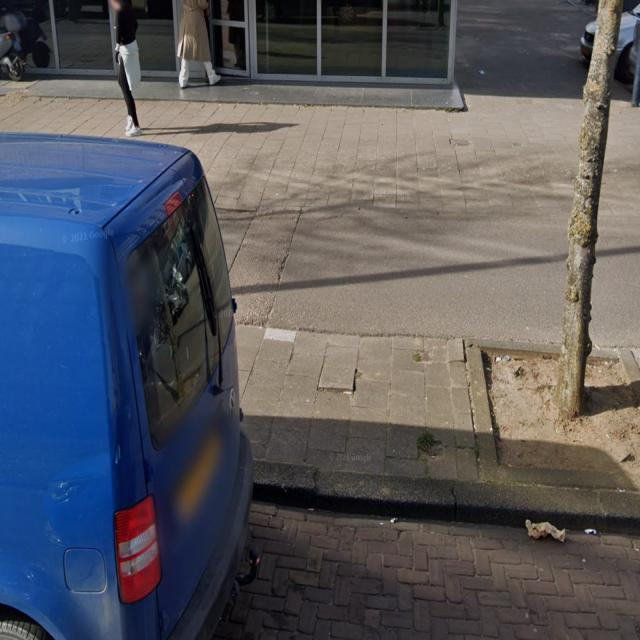

In [ ]:
dataset[0]["filename"]

And the corresponding image

In [ ]:
dataset[0]["narrative 2"]

"There's some minor damage ahead on the sidewalk in front of you. It’s manageable, so you can walk over it as you usually would. If you’d like, you can slightly veer to the right for a more comfortable passage. Just stay relaxed and enjoy your walk!"

## Create PyTorch Dataset

The lines below are entirely copied from the original notebook!

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["filename"], text=item["narrative 2"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

## Load model and processor

In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Now that we have loaded the processor, let's load the dataset and the dataloader:

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(10):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Streaming output truncated to the last 5000 lines.
Loss: 0.09598305821418762
Loss: 0.09090016037225723
Loss: 0.07562163472175598
Loss: 0.0845353901386261
Loss: 0.10350443422794342
Loss: 0.10074783861637115
Loss: 0.10012727230787277
Loss: 0.07335030287504196
Loss: 0.1299610584974289
Loss: 0.11917736381292343
Loss: 0.08242769539356232
Loss: 0.07610692828893661
Loss: 0.09670744091272354
Loss: 0.08346971869468689
Loss: 0.08300512284040451
Loss: 0.10892391949892044
Loss: 0.07033699005842209
Loss: 0.09260465949773788
Loss: 0.08011805266141891
Loss: 0.14039982855319977
Loss: 0.08404868096113205
Loss: 0.0958087369799614
Loss: 0.08476143330335617
Loss: 0.06618428230285645
Loss: 0.06856318563222885
Loss: 0.0653616264462471
Loss: 0.11392234265804291
Loss: 0.07073202729225159
Loss: 0.08061270415782928
Loss: 0.14897631108760834
Loss: 0.08632729947566986
Loss: 0.07233743369579315
Loss: 0.08894609659910202
Loss: 0.09354647994041443
Loss: 0.08942560851573944
Loss: 0.07140401750802994
Loss: 0.093133889

## Inference

Let's check the results on our train dataset

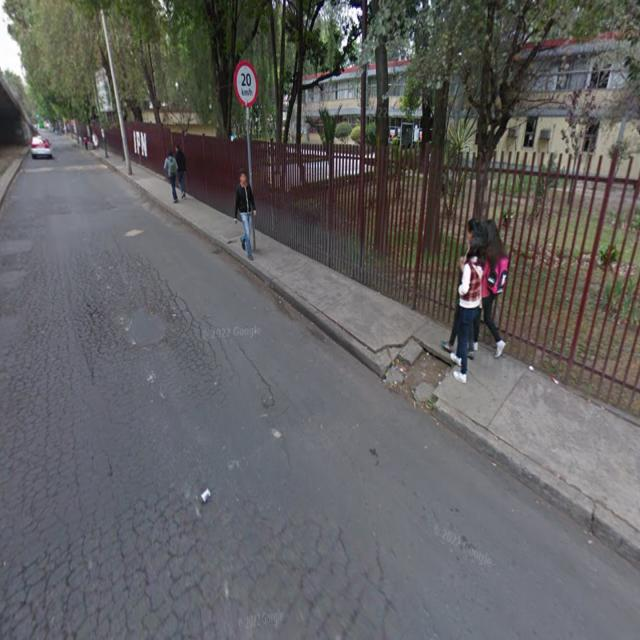

In [ ]:
# load image
example = dataset[1]
image = example["filename"]
image

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=100)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

there ' s some damage ahead on the sidewalk, and it ' s best to approach it slowly and cautiously. it seems to be fairly noticeable, so keep your feet steady and attentive. if you prefer, you can slightly veer to the right to navigate around it safely. take your time, and you ' ll navigate through this smoothly!


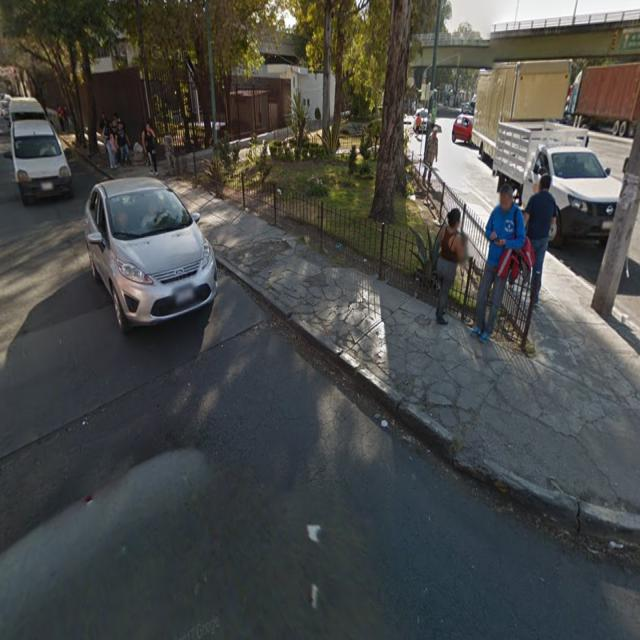

In [ ]:
# load image
example = dataset[2]
image = example["filename"]
image

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=100)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

there ' s some damage ahead on the sidewalk, and it ' s best to approach it slowly and cautiously. it seems to be fairly noticeable, so keep your feet steady and attentive. if you prefer, you can slightly veer to the right to navigate around it safely. take your time, and you ' ll navigate through this smoothly!


## Load from the Hub

Once trained you can push the model and processor on the Hub to use them later.
Meanwhile you can play with the model that we have fine-tuned!

In [ ]:
from transformers import BlipForConditionalGeneration, AutoProcessor

model = BlipForConditionalGeneration.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned").to(device)
processor = AutoProcessor.from_pretrained("ybelkada/blip-image-captioning-base-football-finetuned")

Downloading:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/990M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/431 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/488 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/712k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Let's check the results on our train dataset!

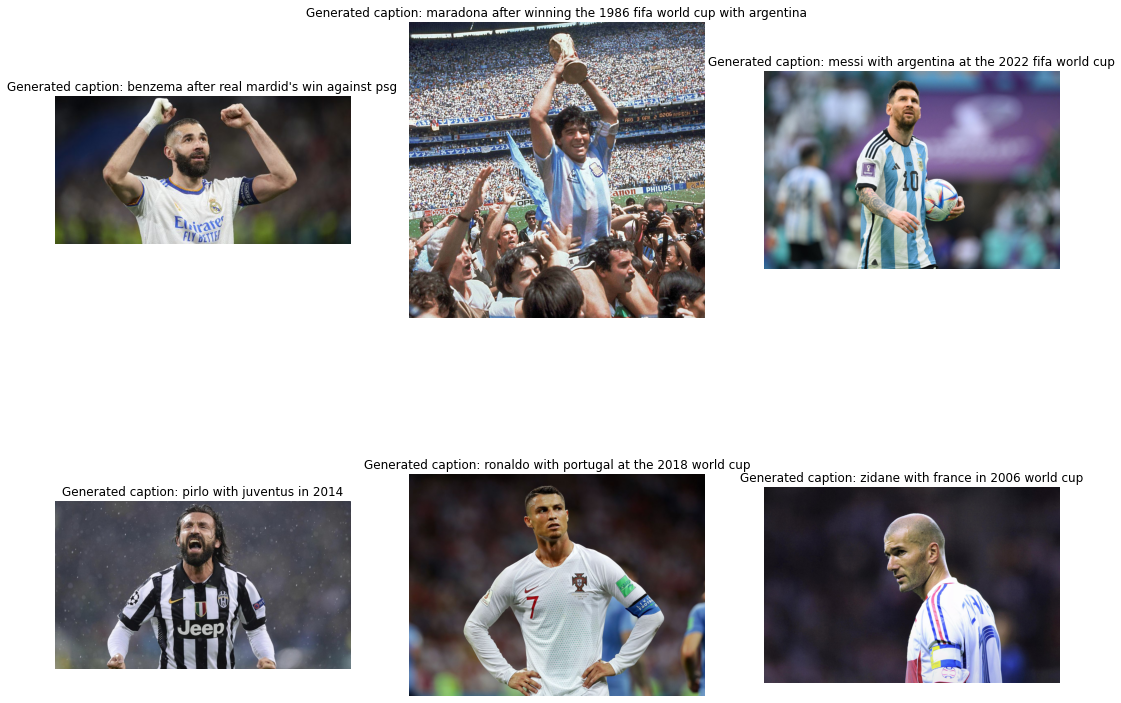

In [ ]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")